# Unsupervised Spectral Unmixing with Autoencoders

By Joshua C. Agar, Shuyu Qin

* There are many times where you want to extract imporant features from high-dimensional data
* In essence, the goal is to compress data to some lower latent space where you can extract information

![](figs/3-swissroll-unfolded.png)

## Autoencoder

![imag](figs/Autoencoder.png)

* **Encoder** - Neural network that deconstructs the data into the most important statistical components
* **Embedding Layer(s)** - One or many layers were information is extracted
* **Decoder** - Neural network that translates the latent space to original dimensionality. 


### Mathematical Objective
* Minimize the reconstruction loss based on some metric. 
  * Mean squared error

  Good at avoiding influence of anomalies
  * Mean absolute error

  Good at capturing details within spectra


### Optimizers
* Standard optimizers like ADAM tend to be sufficient
* Can use more complex optimizers 2nd order, adhessian to optimize small models. 


### Practical Objective
* Create an autoencoder that has performant reconstruction
* Create a low-dimensional and interpretable latent space
  * Reduce the dimensionality
  * Impose non-negativity contraints
  * Impose regularization
  * Impose sparsity
  * Impose constraints on the shape of the latent distribution
  * Impose soft-constraints that favor disentanglement
* Create a latent trajectory that is suitable for generation 

# Imports Packages

In [72]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import copy

# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torch
from tqdm import tqdm
import os

from torchsummary import summary

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

from m3_learning.util.data_generators import generate_data
from m3_learning.viz.layout import layout_fig, embedding_maps, latent_generator
from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn, loss_function


# Generating Data
* We want to generate a hyperspectral image
* This can be done by taking the RGB values of an image and using them as parameters for a function

## Loads and image of my dog Nala
* Painting by *Irene Dogmatic*

In [3]:
# Loads dog image
image = io.imread("./figs/nala.jpg")

# Crops dog image
image = image[200:1900:20, 100:1500:20] / 255


## Displays the image

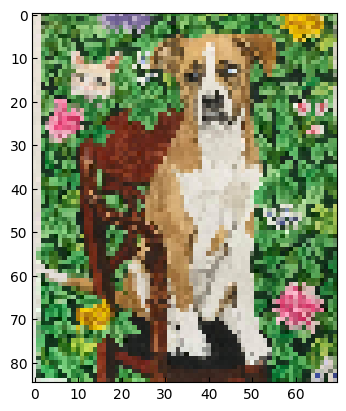

In [4]:
plt.imshow(image)


## Generating some data based on the image
### Define a non-linear function

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/generated.png?raw=true)

In [5]:
def non_linear_fn(t, x, y, z):
    tanh = nn.Tanh()
    selu = nn.SELU()
    sigmoid = nn.Sigmoid()

    # returns a function from variables
    return (
        tanh(torch.tensor(20 * (t - 2 * (x - 0.5))))
        + selu(torch.tensor((t - 2 * (y - 0.5))))
        + sigmoid(torch.tensor(-20 * (t - (z - 0.5))))
    )


In [6]:
# generates a hyperspectral image
dog_data = generate_data(image.reshape(-1, 3), length=10, function=non_linear_fn)


In [7]:
# Conducts a test train split.
# because we are training an autoencoder x and y are the same
X_train, X_test, _, _ = train_test_split(
    dog_data, dog_data, test_size=0.2, random_state=42
)


## Plots the generated data

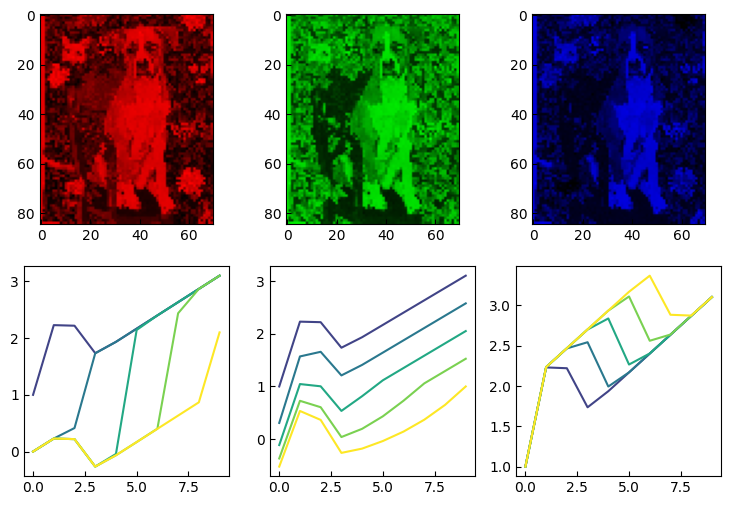

In [8]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)


# Let's Build a Simple Autoencoder

## Defines the encoder and the decoder

In [9]:
latent_dim = 12


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.dense_1 = nn.Linear(10, self.latent_dim)

    def forward(self, x):
        # single dense layer in the model
        x = self.dense_1(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.dense_1 = nn.Linear(self.latent_dim, 10)

    def forward(self, x):
        # single dense layer in the decoder
        x = self.dense_1(x)
        return x


## Builds the autoencoder

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        # encode
        embedding = self.encoder(x)
        # decode
        predicted = self.decoder(embedding)

        return predicted


# Instantiates the model

In [11]:
import cpuinfo
cpudata = cpuinfo.get_cpu_info()['brand_raw']
cpuname = cpudata.split(" ")[1]

if cpuname == 'M1':
    device = "mps"
elif torch.cuda.device_count():
    device = "cuda"
else: 
    device = "cpu"

print(f'You are running on a {device}')

encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


You are running on a cuda


In [12]:
try: 
    summary(model, ((X_train.shape[1:])))
except:
    model_cpu = copy.deepcopy(model).to('cpu')
    summary(model_cpu, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]             132
           Encoder-2                   [-1, 12]               0
            Linear-3                   [-1, 10]             130
           Decoder-4                   [-1, 10]               0
Total params: 262
Trainable params: 262
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


* Encoder with 12 latent dimensions
* Decoder with with size 10 --> same as orignal spectral length
* Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample

In [13]:
train_iterator = torch.utils.data.DataLoader(X_train, batch_size=256, shuffle=True)


In [14]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device = device)


100%|██████████| 19/19 [00:00<00:00, 372.61it/s]


Epoch 0, Train Loss: 2.1838
.............................


100%|██████████| 19/19 [00:00<00:00, 542.92it/s]


Epoch 1, Train Loss: 2.0213
.............................


100%|██████████| 19/19 [00:00<00:00, 542.84it/s]


Epoch 2, Train Loss: 1.8726
.............................


100%|██████████| 19/19 [00:00<00:00, 575.89it/s]


Epoch 3, Train Loss: 1.7309
.............................


100%|██████████| 19/19 [00:00<00:00, 500.04it/s]


Epoch 4, Train Loss: 1.5917
.............................


100%|██████████| 19/19 [00:00<00:00, 575.74it/s]


Epoch 5, Train Loss: 1.4562
.............................


100%|██████████| 19/19 [00:00<00:00, 703.72it/s]


Epoch 6, Train Loss: 1.3241
.............................


100%|██████████| 19/19 [00:00<00:00, 575.47it/s]


Epoch 7, Train Loss: 1.1939
.............................


100%|██████████| 19/19 [00:00<00:00, 678.74it/s]


Epoch 8, Train Loss: 1.0686
.............................


100%|██████████| 19/19 [00:00<00:00, 633.02it/s]


Epoch 9, Train Loss: 0.9512
.............................


100%|██████████| 19/19 [00:00<00:00, 655.28it/s]


Epoch 10, Train Loss: 0.8396
.............................


100%|██████████| 19/19 [00:00<00:00, 703.44it/s]


Epoch 11, Train Loss: 0.7379
.............................


100%|██████████| 19/19 [00:00<00:00, 703.91it/s]


Epoch 12, Train Loss: 0.6461
.............................


100%|██████████| 19/19 [00:00<00:00, 633.33it/s]


Epoch 13, Train Loss: 0.5658
.............................


100%|██████████| 19/19 [00:00<00:00, 593.47it/s]


Epoch 14, Train Loss: 0.4957
.............................


100%|██████████| 19/19 [00:00<00:00, 513.72it/s]


Epoch 15, Train Loss: 0.4374
.............................


100%|██████████| 19/19 [00:00<00:00, 542.83it/s]


Epoch 16, Train Loss: 0.3884
.............................


100%|██████████| 19/19 [00:00<00:00, 558.51it/s]


Epoch 17, Train Loss: 0.3474
.............................


100%|██████████| 19/19 [00:00<00:00, 593.69it/s]


Epoch 18, Train Loss: 0.3139
.............................


100%|██████████| 19/19 [00:00<00:00, 678.55it/s]


Epoch 19, Train Loss: 0.2872
.............................


100%|██████████| 19/19 [00:00<00:00, 703.72it/s]


Epoch 20, Train Loss: 0.2654
.............................


100%|██████████| 19/19 [00:00<00:00, 678.54it/s]


Epoch 21, Train Loss: 0.2476
.............................


100%|██████████| 19/19 [00:00<00:00, 678.41it/s]


Epoch 22, Train Loss: 0.2328
.............................


100%|██████████| 19/19 [00:00<00:00, 431.51it/s]


Epoch 23, Train Loss: 0.2208
.............................


100%|██████████| 19/19 [00:00<00:00, 704.20it/s]


Epoch 24, Train Loss: 0.2110
.............................


100%|██████████| 19/19 [00:00<00:00, 730.84it/s]


Epoch 25, Train Loss: 0.2026
.............................


100%|██████████| 19/19 [00:00<00:00, 730.75it/s]


Epoch 26, Train Loss: 0.1956
.............................


100%|██████████| 19/19 [00:00<00:00, 730.93it/s]


Epoch 27, Train Loss: 0.1900
.............................


100%|██████████| 19/19 [00:00<00:00, 678.20it/s]


Epoch 28, Train Loss: 0.1849
.............................


100%|██████████| 19/19 [00:00<00:00, 730.62it/s]


Epoch 29, Train Loss: 0.1805
.............................


100%|██████████| 19/19 [00:00<00:00, 730.45it/s]


Epoch 30, Train Loss: 0.1765
.............................


100%|██████████| 19/19 [00:00<00:00, 633.01it/s]


Epoch 31, Train Loss: 0.1724
.............................


100%|██████████| 19/19 [00:00<00:00, 730.35it/s]


Epoch 32, Train Loss: 0.1694
.............................


100%|██████████| 19/19 [00:00<00:00, 633.84it/s]


Epoch 33, Train Loss: 0.1661
.............................


100%|██████████| 19/19 [00:00<00:00, 679.04it/s]


Epoch 34, Train Loss: 0.1633
.............................


100%|██████████| 19/19 [00:00<00:00, 703.95it/s]


Epoch 35, Train Loss: 0.1604
.............................


100%|██████████| 19/19 [00:00<00:00, 633.92it/s]


Epoch 36, Train Loss: 0.1581
.............................


100%|██████████| 19/19 [00:00<00:00, 703.55it/s]


Epoch 37, Train Loss: 0.1551
.............................


100%|██████████| 19/19 [00:00<00:00, 559.09it/s]


Epoch 38, Train Loss: 0.1527
.............................


100%|██████████| 19/19 [00:00<00:00, 612.94it/s]


Epoch 39, Train Loss: 0.1500
.............................


100%|██████████| 19/19 [00:00<00:00, 678.66it/s]


Epoch 40, Train Loss: 0.1479
.............................


100%|██████████| 19/19 [00:00<00:00, 731.01it/s]


Epoch 41, Train Loss: 0.1454
.............................


100%|██████████| 19/19 [00:00<00:00, 632.83it/s]


Epoch 42, Train Loss: 0.1432
.............................


100%|██████████| 19/19 [00:00<00:00, 559.16it/s]


Epoch 43, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 678.59it/s]


Epoch 44, Train Loss: 0.1386
.............................


100%|██████████| 19/19 [00:00<00:00, 759.56it/s]


Epoch 45, Train Loss: 0.1365
.............................


100%|██████████| 19/19 [00:00<00:00, 613.20it/s]


Epoch 46, Train Loss: 0.1343
.............................


100%|██████████| 19/19 [00:00<00:00, 759.71it/s]


Epoch 47, Train Loss: 0.1321
.............................


100%|██████████| 19/19 [00:00<00:00, 633.16it/s]


Epoch 48, Train Loss: 0.1299
.............................


100%|██████████| 19/19 [00:00<00:00, 678.67it/s]


Epoch 49, Train Loss: 0.1278
.............................


100%|██████████| 19/19 [00:00<00:00, 594.04it/s]


Epoch 50, Train Loss: 0.1256
.............................


100%|██████████| 19/19 [00:00<00:00, 612.22it/s]


Epoch 51, Train Loss: 0.1234
.............................


100%|██████████| 19/19 [00:00<00:00, 527.96it/s]


Epoch 52, Train Loss: 0.1214
.............................


100%|██████████| 19/19 [00:00<00:00, 576.23it/s]


Epoch 53, Train Loss: 0.1193
.............................


100%|██████████| 19/19 [00:00<00:00, 731.16it/s]


Epoch 54, Train Loss: 0.1173
.............................


100%|██████████| 19/19 [00:00<00:00, 703.33it/s]


Epoch 55, Train Loss: 0.1151
.............................


100%|██████████| 19/19 [00:00<00:00, 703.74it/s]


Epoch 56, Train Loss: 0.1132
.............................


100%|██████████| 19/19 [00:00<00:00, 613.30it/s]


Epoch 57, Train Loss: 0.1111
.............................


100%|██████████| 19/19 [00:00<00:00, 612.95it/s]


Epoch 58, Train Loss: 0.1091
.............................


100%|██████████| 19/19 [00:00<00:00, 429.70it/s]


Epoch 59, Train Loss: 0.1071
.............................


100%|██████████| 19/19 [00:00<00:00, 655.14it/s]


Epoch 60, Train Loss: 0.1052
.............................


100%|██████████| 19/19 [00:00<00:00, 759.66it/s]


Epoch 61, Train Loss: 0.1033
.............................


100%|██████████| 19/19 [00:00<00:00, 730.94it/s]


Epoch 62, Train Loss: 0.1012
.............................


100%|██████████| 19/19 [00:00<00:00, 791.68it/s]


Epoch 63, Train Loss: 0.0993
.............................


100%|██████████| 19/19 [00:00<00:00, 791.65it/s]


Epoch 64, Train Loss: 0.0976
.............................


100%|██████████| 19/19 [00:00<00:00, 594.01it/s]


Epoch 65, Train Loss: 0.0956
.............................


100%|██████████| 19/19 [00:00<00:00, 422.38it/s]


Epoch 66, Train Loss: 0.0938
.............................


100%|██████████| 19/19 [00:00<00:00, 612.33it/s]


Epoch 67, Train Loss: 0.0921
.............................


100%|██████████| 19/19 [00:00<00:00, 612.98it/s]


Epoch 68, Train Loss: 0.0903
.............................


100%|██████████| 19/19 [00:00<00:00, 730.83it/s]


Epoch 69, Train Loss: 0.0885
.............................


100%|██████████| 19/19 [00:00<00:00, 655.02it/s]


Epoch 70, Train Loss: 0.0867
.............................


100%|██████████| 19/19 [00:00<00:00, 655.53it/s]


Epoch 71, Train Loss: 0.0851
.............................


100%|██████████| 19/19 [00:00<00:00, 703.79it/s]


Epoch 72, Train Loss: 0.0832
.............................


100%|██████████| 19/19 [00:00<00:00, 703.70it/s]


Epoch 73, Train Loss: 0.0819
.............................


100%|██████████| 19/19 [00:00<00:00, 703.96it/s]


Epoch 74, Train Loss: 0.0802
.............................


100%|██████████| 19/19 [00:00<00:00, 387.85it/s]


Epoch 75, Train Loss: 0.0786
.............................


100%|██████████| 19/19 [00:00<00:00, 593.77it/s]


Epoch 76, Train Loss: 0.0770
.............................


100%|██████████| 19/19 [00:00<00:00, 655.23it/s]


Epoch 77, Train Loss: 0.0754
.............................


100%|██████████| 19/19 [00:00<00:00, 513.49it/s]


Epoch 78, Train Loss: 0.0740
.............................


100%|██████████| 19/19 [00:00<00:00, 678.52it/s]


Epoch 79, Train Loss: 0.0725
.............................


100%|██████████| 19/19 [00:00<00:00, 703.74it/s]


Epoch 80, Train Loss: 0.0710
.............................


100%|██████████| 19/19 [00:00<00:00, 791.73it/s]


Epoch 81, Train Loss: 0.0696
.............................


100%|██████████| 19/19 [00:00<00:00, 730.39it/s]


Epoch 82, Train Loss: 0.0683
.............................


100%|██████████| 19/19 [00:00<00:00, 730.82it/s]


Epoch 83, Train Loss: 0.0670
.............................


100%|██████████| 19/19 [00:00<00:00, 475.35it/s]


Epoch 84, Train Loss: 0.0657
.............................


100%|██████████| 19/19 [00:00<00:00, 634.06it/s]


Epoch 85, Train Loss: 0.0645
.............................


100%|██████████| 19/19 [00:00<00:00, 703.75it/s]


Epoch 86, Train Loss: 0.0632
.............................


100%|██████████| 19/19 [00:00<00:00, 633.15it/s]


Epoch 87, Train Loss: 0.0621
.............................


100%|██████████| 19/19 [00:00<00:00, 731.06it/s]


Epoch 88, Train Loss: 0.0608
.............................


100%|██████████| 19/19 [00:00<00:00, 542.90it/s]


Epoch 89, Train Loss: 0.0595
.............................


100%|██████████| 19/19 [00:00<00:00, 679.03it/s]


Epoch 90, Train Loss: 0.0585
.............................


100%|██████████| 19/19 [00:00<00:00, 559.26it/s]


Epoch 91, Train Loss: 0.0575
.............................


100%|██████████| 19/19 [00:00<00:00, 527.85it/s]


Epoch 92, Train Loss: 0.0564
.............................


100%|██████████| 19/19 [00:00<00:00, 654.41it/s]


Epoch 93, Train Loss: 0.0554
.............................


100%|██████████| 19/19 [00:00<00:00, 731.02it/s]


Epoch 94, Train Loss: 0.0543
.............................


100%|██████████| 19/19 [00:00<00:00, 654.88it/s]


Epoch 95, Train Loss: 0.0534
.............................


100%|██████████| 19/19 [00:00<00:00, 678.70it/s]


Epoch 96, Train Loss: 0.0525
.............................


100%|██████████| 19/19 [00:00<00:00, 731.44it/s]


Epoch 97, Train Loss: 0.0515
.............................


100%|██████████| 19/19 [00:00<00:00, 613.10it/s]


Epoch 98, Train Loss: 0.0507
.............................


100%|██████████| 19/19 [00:00<00:00, 499.50it/s]


Epoch 99, Train Loss: 0.0498
.............................


100%|██████████| 19/19 [00:00<00:00, 633.60it/s]


Epoch 100, Train Loss: 0.0489
.............................


100%|██████████| 19/19 [00:00<00:00, 730.57it/s]


Epoch 101, Train Loss: 0.0481
.............................


100%|██████████| 19/19 [00:00<00:00, 730.80it/s]


Epoch 102, Train Loss: 0.0474
.............................


100%|██████████| 19/19 [00:00<00:00, 656.39it/s]


Epoch 103, Train Loss: 0.0466
.............................


100%|██████████| 19/19 [00:00<00:00, 593.82it/s]


Epoch 104, Train Loss: 0.0459
.............................


100%|██████████| 19/19 [00:00<00:00, 576.21it/s]


Epoch 105, Train Loss: 0.0452
.............................


100%|██████████| 19/19 [00:00<00:00, 575.74it/s]


Epoch 106, Train Loss: 0.0445
.............................


100%|██████████| 19/19 [00:00<00:00, 633.80it/s]


Epoch 107, Train Loss: 0.0438
.............................


100%|██████████| 19/19 [00:00<00:00, 703.98it/s]


Epoch 108, Train Loss: 0.0431
.............................


100%|██████████| 19/19 [00:00<00:00, 633.36it/s]


Epoch 109, Train Loss: 0.0425
.............................


100%|██████████| 19/19 [00:00<00:00, 655.91it/s]


Epoch 110, Train Loss: 0.0420
.............................


100%|██████████| 19/19 [00:00<00:00, 558.84it/s]


Epoch 111, Train Loss: 0.0413
.............................


100%|██████████| 19/19 [00:00<00:00, 703.43it/s]


Epoch 112, Train Loss: 0.0408
.............................


100%|██████████| 19/19 [00:00<00:00, 759.37it/s]


Epoch 113, Train Loss: 0.0401
.............................


100%|██████████| 19/19 [00:00<00:00, 704.94it/s]


Epoch 114, Train Loss: 0.0397
.............................


100%|██████████| 19/19 [00:00<00:00, 678.53it/s]


Epoch 115, Train Loss: 0.0392
.............................


100%|██████████| 19/19 [00:00<00:00, 703.78it/s]


Epoch 116, Train Loss: 0.0387
.............................


100%|██████████| 19/19 [00:00<00:00, 730.77it/s]


Epoch 117, Train Loss: 0.0381
.............................


100%|██████████| 19/19 [00:00<00:00, 678.48it/s]


Epoch 118, Train Loss: 0.0376
.............................


100%|██████████| 19/19 [00:00<00:00, 731.07it/s]


Epoch 119, Train Loss: 0.0373
.............................


100%|██████████| 19/19 [00:00<00:00, 575.88it/s]


Epoch 120, Train Loss: 0.0367
.............................


100%|██████████| 19/19 [00:00<00:00, 542.52it/s]


Epoch 121, Train Loss: 0.0363
.............................


100%|██████████| 19/19 [00:00<00:00, 730.90it/s]


Epoch 122, Train Loss: 0.0359
.............................


100%|██████████| 19/19 [00:00<00:00, 758.88it/s]


Epoch 123, Train Loss: 0.0356
.............................


100%|██████████| 19/19 [00:00<00:00, 703.86it/s]


Epoch 124, Train Loss: 0.0351
.............................


100%|██████████| 19/19 [00:00<00:00, 594.04it/s]


Epoch 125, Train Loss: 0.0348
.............................


100%|██████████| 19/19 [00:00<00:00, 574.92it/s]


Epoch 126, Train Loss: 0.0344
.............................


100%|██████████| 19/19 [00:00<00:00, 593.13it/s]


Epoch 127, Train Loss: 0.0341
.............................


100%|██████████| 19/19 [00:00<00:00, 422.14it/s]


Epoch 128, Train Loss: 0.0337
.............................


100%|██████████| 19/19 [00:00<00:00, 593.98it/s]


Epoch 129, Train Loss: 0.0333
.............................


100%|██████████| 19/19 [00:00<00:00, 678.50it/s]


Epoch 130, Train Loss: 0.0331
.............................


100%|██████████| 19/19 [00:00<00:00, 791.51it/s]


Epoch 131, Train Loss: 0.0327
.............................


100%|██████████| 19/19 [00:00<00:00, 791.80it/s]


Epoch 132, Train Loss: 0.0324
.............................


100%|██████████| 19/19 [00:00<00:00, 825.45it/s]


Epoch 133, Train Loss: 0.0321
.............................


100%|██████████| 19/19 [00:00<00:00, 791.82it/s]


Epoch 134, Train Loss: 0.0318
.............................


100%|██████████| 19/19 [00:00<00:00, 543.07it/s]


Epoch 135, Train Loss: 0.0315
.............................


100%|██████████| 19/19 [00:00<00:00, 613.07it/s]


Epoch 136, Train Loss: 0.0312
.............................


100%|██████████| 19/19 [00:00<00:00, 655.60it/s]


Epoch 137, Train Loss: 0.0309
.............................


100%|██████████| 19/19 [00:00<00:00, 791.46it/s]


Epoch 138, Train Loss: 0.0307
.............................


100%|██████████| 19/19 [00:00<00:00, 678.43it/s]


Epoch 139, Train Loss: 0.0304
.............................


100%|██████████| 19/19 [00:00<00:00, 703.59it/s]


Epoch 140, Train Loss: 0.0301
.............................


100%|██████████| 19/19 [00:00<00:00, 576.03it/s]


Epoch 141, Train Loss: 0.0299
.............................


100%|██████████| 19/19 [00:00<00:00, 703.81it/s]


Epoch 142, Train Loss: 0.0297
.............................


100%|██████████| 19/19 [00:00<00:00, 730.71it/s]


Epoch 143, Train Loss: 0.0295
.............................


100%|██████████| 19/19 [00:00<00:00, 703.66it/s]


Epoch 144, Train Loss: 0.0292
.............................


100%|██████████| 19/19 [00:00<00:00, 678.15it/s]


Epoch 145, Train Loss: 0.0290
.............................


100%|██████████| 19/19 [00:00<00:00, 633.08it/s]


Epoch 146, Train Loss: 0.0287
.............................


100%|██████████| 19/19 [00:00<00:00, 678.59it/s]


Epoch 147, Train Loss: 0.0285
.............................


100%|██████████| 19/19 [00:00<00:00, 678.46it/s]


Epoch 148, Train Loss: 0.0283
.............................


100%|██████████| 19/19 [00:00<00:00, 633.57it/s]


Epoch 149, Train Loss: 0.0281
.............................


100%|██████████| 19/19 [00:00<00:00, 559.36it/s]


Epoch 150, Train Loss: 0.0279
.............................


100%|██████████| 19/19 [00:00<00:00, 612.92it/s]


Epoch 151, Train Loss: 0.0277
.............................


100%|██████████| 19/19 [00:00<00:00, 633.44it/s]


Epoch 152, Train Loss: 0.0274
.............................


100%|██████████| 19/19 [00:00<00:00, 655.80it/s]


Epoch 153, Train Loss: 0.0272
.............................


100%|██████████| 19/19 [00:00<00:00, 704.44it/s]


Epoch 154, Train Loss: 0.0270
.............................


100%|██████████| 19/19 [00:00<00:00, 474.96it/s]


Epoch 155, Train Loss: 0.0269
.............................


100%|██████████| 19/19 [00:00<00:00, 702.82it/s]


Epoch 156, Train Loss: 0.0266
.............................


100%|██████████| 19/19 [00:00<00:00, 678.51it/s]


Epoch 157, Train Loss: 0.0264
.............................


100%|██████████| 19/19 [00:00<00:00, 703.40it/s]


Epoch 158, Train Loss: 0.0263
.............................


100%|██████████| 19/19 [00:00<00:00, 633.42it/s]


Epoch 159, Train Loss: 0.0260
.............................


100%|██████████| 19/19 [00:00<00:00, 612.52it/s]


Epoch 160, Train Loss: 0.0258
.............................


100%|██████████| 19/19 [00:00<00:00, 703.75it/s]


Epoch 161, Train Loss: 0.0256
.............................


100%|██████████| 19/19 [00:00<00:00, 730.94it/s]


Epoch 162, Train Loss: 0.0255
.............................


100%|██████████| 19/19 [00:00<00:00, 731.23it/s]


Epoch 163, Train Loss: 0.0252
.............................


100%|██████████| 19/19 [00:00<00:00, 462.99it/s]


Epoch 164, Train Loss: 0.0250
.............................


100%|██████████| 19/19 [00:00<00:00, 527.83it/s]


Epoch 165, Train Loss: 0.0249
.............................


100%|██████████| 19/19 [00:00<00:00, 703.51it/s]


Epoch 166, Train Loss: 0.0247
.............................


100%|██████████| 19/19 [00:00<00:00, 729.04it/s]


Epoch 167, Train Loss: 0.0246
.............................


100%|██████████| 19/19 [00:00<00:00, 703.72it/s]


Epoch 168, Train Loss: 0.0243
.............................


100%|██████████| 19/19 [00:00<00:00, 413.23it/s]


Epoch 169, Train Loss: 0.0242
.............................


100%|██████████| 19/19 [00:00<00:00, 558.01it/s]


Epoch 170, Train Loss: 0.0239
.............................


100%|██████████| 19/19 [00:00<00:00, 703.64it/s]


Epoch 171, Train Loss: 0.0237
.............................


100%|██████████| 19/19 [00:00<00:00, 703.47it/s]


Epoch 172, Train Loss: 0.0236
.............................


100%|██████████| 19/19 [00:00<00:00, 730.77it/s]


Epoch 173, Train Loss: 0.0234
.............................


100%|██████████| 19/19 [00:00<00:00, 396.20it/s]


Epoch 174, Train Loss: 0.0232
.............................


100%|██████████| 19/19 [00:00<00:00, 712.03it/s]


Epoch 175, Train Loss: 0.0230
.............................


100%|██████████| 19/19 [00:00<00:00, 730.48it/s]


Epoch 176, Train Loss: 0.0228
.............................


100%|██████████| 19/19 [00:00<00:00, 731.87it/s]


Epoch 177, Train Loss: 0.0227
.............................


100%|██████████| 19/19 [00:00<00:00, 613.03it/s]


Epoch 178, Train Loss: 0.0225
.............................


100%|██████████| 19/19 [00:00<00:00, 594.24it/s]


Epoch 179, Train Loss: 0.0223
.............................


100%|██████████| 19/19 [00:00<00:00, 791.23it/s]


Epoch 180, Train Loss: 0.0220
.............................


100%|██████████| 19/19 [00:00<00:00, 678.35it/s]


Epoch 181, Train Loss: 0.0219
.............................


100%|██████████| 19/19 [00:00<00:00, 678.61it/s]


Epoch 182, Train Loss: 0.0217
.............................


100%|██████████| 19/19 [00:00<00:00, 655.15it/s]


Epoch 183, Train Loss: 0.0215
.............................


100%|██████████| 19/19 [00:00<00:00, 633.67it/s]


Epoch 184, Train Loss: 0.0214
.............................


100%|██████████| 19/19 [00:00<00:00, 613.00it/s]


Epoch 185, Train Loss: 0.0211
.............................


100%|██████████| 19/19 [00:00<00:00, 528.02it/s]


Epoch 186, Train Loss: 0.0210
.............................


100%|██████████| 19/19 [00:00<00:00, 404.53it/s]


Epoch 187, Train Loss: 0.0208
.............................


100%|██████████| 19/19 [00:00<00:00, 497.47it/s]


Epoch 188, Train Loss: 0.0206
.............................


100%|██████████| 19/19 [00:00<00:00, 682.74it/s]


Epoch 189, Train Loss: 0.0204
.............................


100%|██████████| 19/19 [00:00<00:00, 658.27it/s]


Epoch 190, Train Loss: 0.0202
.............................


100%|██████████| 19/19 [00:00<00:00, 680.93it/s]


Epoch 191, Train Loss: 0.0201
.............................


100%|██████████| 19/19 [00:00<00:00, 527.80it/s]


Epoch 192, Train Loss: 0.0200
.............................


100%|██████████| 19/19 [00:00<00:00, 678.16it/s]


Epoch 193, Train Loss: 0.0197
.............................


100%|██████████| 19/19 [00:00<00:00, 703.77it/s]


Epoch 194, Train Loss: 0.0195
.............................


100%|██████████| 19/19 [00:00<00:00, 655.09it/s]


Epoch 195, Train Loss: 0.0194
.............................


100%|██████████| 19/19 [00:00<00:00, 633.68it/s]


Epoch 196, Train Loss: 0.0193
.............................


100%|██████████| 19/19 [00:00<00:00, 593.64it/s]


Epoch 197, Train Loss: 0.0191
.............................


100%|██████████| 19/19 [00:00<00:00, 703.53it/s]


Epoch 198, Train Loss: 0.0189
.............................


100%|██████████| 19/19 [00:00<00:00, 703.61it/s]


Epoch 199, Train Loss: 0.0187
.............................


100%|██████████| 19/19 [00:00<00:00, 703.70it/s]


Epoch 200, Train Loss: 0.0185
.............................


100%|██████████| 19/19 [00:00<00:00, 731.08it/s]


Epoch 201, Train Loss: 0.0183
.............................


100%|██████████| 19/19 [00:00<00:00, 655.04it/s]


Epoch 202, Train Loss: 0.0182
.............................


100%|██████████| 19/19 [00:00<00:00, 613.09it/s]


Epoch 203, Train Loss: 0.0180
.............................


100%|██████████| 19/19 [00:00<00:00, 703.43it/s]


Epoch 204, Train Loss: 0.0178
.............................


100%|██████████| 19/19 [00:00<00:00, 655.67it/s]


Epoch 205, Train Loss: 0.0177
.............................


100%|██████████| 19/19 [00:00<00:00, 613.05it/s]


Epoch 206, Train Loss: 0.0175
.............................


100%|██████████| 19/19 [00:00<00:00, 633.65it/s]


Epoch 207, Train Loss: 0.0173
.............................


100%|██████████| 19/19 [00:00<00:00, 730.71it/s]


Epoch 208, Train Loss: 0.0172
.............................


100%|██████████| 19/19 [00:00<00:00, 703.87it/s]


Epoch 209, Train Loss: 0.0170
.............................


100%|██████████| 19/19 [00:00<00:00, 542.84it/s]


Epoch 210, Train Loss: 0.0168
.............................


100%|██████████| 19/19 [00:00<00:00, 678.84it/s]


Epoch 211, Train Loss: 0.0167
.............................


100%|██████████| 19/19 [00:00<00:00, 791.79it/s]


Epoch 212, Train Loss: 0.0165
.............................


100%|██████████| 19/19 [00:00<00:00, 655.04it/s]


Epoch 213, Train Loss: 0.0164
.............................


100%|██████████| 19/19 [00:00<00:00, 633.70it/s]


Epoch 214, Train Loss: 0.0162
.............................


100%|██████████| 19/19 [00:00<00:00, 703.83it/s]


Epoch 215, Train Loss: 0.0161
.............................


100%|██████████| 19/19 [00:00<00:00, 633.25it/s]


Epoch 216, Train Loss: 0.0159
.............................


100%|██████████| 19/19 [00:00<00:00, 678.09it/s]


Epoch 217, Train Loss: 0.0157
.............................


100%|██████████| 19/19 [00:00<00:00, 559.05it/s]


Epoch 218, Train Loss: 0.0155
.............................


100%|██████████| 19/19 [00:00<00:00, 703.33it/s]


Epoch 219, Train Loss: 0.0154
.............................


100%|██████████| 19/19 [00:00<00:00, 655.45it/s]


Epoch 220, Train Loss: 0.0152
.............................


100%|██████████| 19/19 [00:00<00:00, 704.35it/s]


Epoch 221, Train Loss: 0.0150
.............................


100%|██████████| 19/19 [00:00<00:00, 704.02it/s]


Epoch 222, Train Loss: 0.0149
.............................


100%|██████████| 19/19 [00:00<00:00, 731.17it/s]


Epoch 223, Train Loss: 0.0148
.............................


100%|██████████| 19/19 [00:00<00:00, 678.34it/s]


Epoch 224, Train Loss: 0.0146
.............................


100%|██████████| 19/19 [00:00<00:00, 703.94it/s]


Epoch 225, Train Loss: 0.0145
.............................


100%|██████████| 19/19 [00:00<00:00, 729.90it/s]


Epoch 226, Train Loss: 0.0142
.............................


100%|██████████| 19/19 [00:00<00:00, 593.71it/s]


Epoch 227, Train Loss: 0.0141
.............................


100%|██████████| 19/19 [00:00<00:00, 395.77it/s]


Epoch 228, Train Loss: 0.0140
.............................


100%|██████████| 19/19 [00:00<00:00, 633.38it/s]


Epoch 229, Train Loss: 0.0138
.............................


100%|██████████| 19/19 [00:00<00:00, 677.67it/s]


Epoch 230, Train Loss: 0.0137
.............................


100%|██████████| 19/19 [00:00<00:00, 730.76it/s]


Epoch 231, Train Loss: 0.0135
.............................


100%|██████████| 19/19 [00:00<00:00, 705.22it/s]


Epoch 232, Train Loss: 0.0133
.............................


100%|██████████| 19/19 [00:00<00:00, 703.68it/s]


Epoch 233, Train Loss: 0.0131
.............................


100%|██████████| 19/19 [00:00<00:00, 758.78it/s]


Epoch 234, Train Loss: 0.0130
.............................


100%|██████████| 19/19 [00:00<00:00, 759.90it/s]


Epoch 235, Train Loss: 0.0129
.............................


100%|██████████| 19/19 [00:00<00:00, 760.45it/s]


Epoch 236, Train Loss: 0.0127
.............................


100%|██████████| 19/19 [00:00<00:00, 678.29it/s]


Epoch 237, Train Loss: 0.0126
.............................


100%|██████████| 19/19 [00:00<00:00, 655.38it/s]


Epoch 238, Train Loss: 0.0124
.............................


100%|██████████| 19/19 [00:00<00:00, 612.74it/s]


Epoch 239, Train Loss: 0.0122
.............................


100%|██████████| 19/19 [00:00<00:00, 679.25it/s]


Epoch 240, Train Loss: 0.0121
.............................


100%|██████████| 19/19 [00:00<00:00, 791.72it/s]


Epoch 241, Train Loss: 0.0119
.............................


100%|██████████| 19/19 [00:00<00:00, 558.97it/s]


Epoch 242, Train Loss: 0.0118
.............................


100%|██████████| 19/19 [00:00<00:00, 655.21it/s]


Epoch 243, Train Loss: 0.0116
.............................


100%|██████████| 19/19 [00:00<00:00, 759.15it/s]


Epoch 244, Train Loss: 0.0114
.............................


100%|██████████| 19/19 [00:00<00:00, 633.38it/s]


Epoch 245, Train Loss: 0.0113
.............................


100%|██████████| 19/19 [00:00<00:00, 730.59it/s]


Epoch 246, Train Loss: 0.0111
.............................


100%|██████████| 19/19 [00:00<00:00, 678.79it/s]


Epoch 247, Train Loss: 0.0110
.............................


100%|██████████| 19/19 [00:00<00:00, 731.24it/s]


Epoch 248, Train Loss: 0.0108
.............................


100%|██████████| 19/19 [00:00<00:00, 703.80it/s]


Epoch 249, Train Loss: 0.0107
.............................


100%|██████████| 19/19 [00:00<00:00, 730.51it/s]


Epoch 250, Train Loss: 0.0105
.............................


100%|██████████| 19/19 [00:00<00:00, 730.52it/s]


Epoch 251, Train Loss: 0.0103
.............................


100%|██████████| 19/19 [00:00<00:00, 706.92it/s]


Epoch 252, Train Loss: 0.0102
.............................


100%|██████████| 19/19 [00:00<00:00, 758.62it/s]


Epoch 253, Train Loss: 0.0100
.............................


100%|██████████| 19/19 [00:00<00:00, 704.37it/s]


Epoch 254, Train Loss: 0.0098
.............................


100%|██████████| 19/19 [00:00<00:00, 827.00it/s]


Epoch 255, Train Loss: 0.0097
.............................


100%|██████████| 19/19 [00:00<00:00, 791.22it/s]


Epoch 256, Train Loss: 0.0095
.............................


100%|██████████| 19/19 [00:00<00:00, 730.76it/s]


Epoch 257, Train Loss: 0.0093
.............................


100%|██████████| 19/19 [00:00<00:00, 791.72it/s]


Epoch 258, Train Loss: 0.0092
.............................


100%|██████████| 19/19 [00:00<00:00, 759.84it/s]


Epoch 259, Train Loss: 0.0090
.............................


100%|██████████| 19/19 [00:00<00:00, 825.98it/s]


Epoch 260, Train Loss: 0.0089
.............................


100%|██████████| 19/19 [00:00<00:00, 759.48it/s]


Epoch 261, Train Loss: 0.0087
.............................


100%|██████████| 19/19 [00:00<00:00, 791.95it/s]


Epoch 262, Train Loss: 0.0085
.............................


100%|██████████| 19/19 [00:00<00:00, 760.37it/s]


Epoch 263, Train Loss: 0.0084
.............................


100%|██████████| 19/19 [00:00<00:00, 528.67it/s]


Epoch 264, Train Loss: 0.0082
.............................


100%|██████████| 19/19 [00:00<00:00, 558.87it/s]


Epoch 265, Train Loss: 0.0081
.............................


100%|██████████| 19/19 [00:00<00:00, 499.61it/s]


Epoch 266, Train Loss: 0.0079
.............................


100%|██████████| 19/19 [00:00<00:00, 655.30it/s]


Epoch 267, Train Loss: 0.0077
.............................


100%|██████████| 19/19 [00:00<00:00, 655.23it/s]


Epoch 268, Train Loss: 0.0076
.............................


100%|██████████| 19/19 [00:00<00:00, 678.70it/s]


Epoch 269, Train Loss: 0.0075
.............................


100%|██████████| 19/19 [00:00<00:00, 703.52it/s]


Epoch 270, Train Loss: 0.0073
.............................


100%|██████████| 19/19 [00:00<00:00, 703.53it/s]


Epoch 271, Train Loss: 0.0071
.............................


100%|██████████| 19/19 [00:00<00:00, 655.20it/s]


Epoch 272, Train Loss: 0.0070
.............................


100%|██████████| 19/19 [00:00<00:00, 655.26it/s]


Epoch 273, Train Loss: 0.0068
.............................


100%|██████████| 19/19 [00:00<00:00, 730.79it/s]


Epoch 274, Train Loss: 0.0067
.............................


100%|██████████| 19/19 [00:00<00:00, 655.78it/s]


Epoch 275, Train Loss: 0.0065
.............................


100%|██████████| 19/19 [00:00<00:00, 592.93it/s]


Epoch 276, Train Loss: 0.0064
.............................


100%|██████████| 19/19 [00:00<00:00, 593.91it/s]


Epoch 277, Train Loss: 0.0063
.............................


100%|██████████| 19/19 [00:00<00:00, 543.29it/s]


Epoch 278, Train Loss: 0.0061
.............................


100%|██████████| 19/19 [00:00<00:00, 613.28it/s]


Epoch 279, Train Loss: 0.0060
.............................


100%|██████████| 19/19 [00:00<00:00, 655.16it/s]


Epoch 280, Train Loss: 0.0059
.............................


100%|██████████| 19/19 [00:00<00:00, 593.64it/s]


Epoch 281, Train Loss: 0.0057
.............................


100%|██████████| 19/19 [00:00<00:00, 593.89it/s]


Epoch 282, Train Loss: 0.0056
.............................


100%|██████████| 19/19 [00:00<00:00, 575.59it/s]


Epoch 283, Train Loss: 0.0054
.............................


100%|██████████| 19/19 [00:00<00:00, 593.82it/s]


Epoch 284, Train Loss: 0.0053
.............................


100%|██████████| 19/19 [00:00<00:00, 633.51it/s]


Epoch 285, Train Loss: 0.0052
.............................


100%|██████████| 19/19 [00:00<00:00, 633.44it/s]


Epoch 286, Train Loss: 0.0051
.............................


100%|██████████| 19/19 [00:00<00:00, 703.95it/s]


Epoch 287, Train Loss: 0.0049
.............................


100%|██████████| 19/19 [00:00<00:00, 678.55it/s]


Epoch 288, Train Loss: 0.0048
.............................


100%|██████████| 19/19 [00:00<00:00, 730.13it/s]


Epoch 289, Train Loss: 0.0047
.............................


100%|██████████| 19/19 [00:00<00:00, 704.13it/s]


Epoch 290, Train Loss: 0.0046
.............................


100%|██████████| 19/19 [00:00<00:00, 678.35it/s]


Epoch 291, Train Loss: 0.0045
.............................


100%|██████████| 19/19 [00:00<00:00, 703.08it/s]


Epoch 292, Train Loss: 0.0044
.............................


100%|██████████| 19/19 [00:00<00:00, 703.97it/s]


Epoch 293, Train Loss: 0.0043
.............................


100%|██████████| 19/19 [00:00<00:00, 678.60it/s]


Epoch 294, Train Loss: 0.0042
.............................


100%|██████████| 19/19 [00:00<00:00, 633.18it/s]


Epoch 295, Train Loss: 0.0041
.............................


100%|██████████| 19/19 [00:00<00:00, 633.42it/s]


Epoch 296, Train Loss: 0.0040
.............................


100%|██████████| 19/19 [00:00<00:00, 576.08it/s]


Epoch 297, Train Loss: 0.0039
.............................


100%|██████████| 19/19 [00:00<00:00, 542.80it/s]


Epoch 298, Train Loss: 0.0038
.............................


100%|██████████| 19/19 [00:00<00:00, 593.15it/s]


Epoch 299, Train Loss: 0.0037
.............................


100%|██████████| 19/19 [00:00<00:00, 558.32it/s]


Epoch 300, Train Loss: 0.0036
.............................


100%|██████████| 19/19 [00:00<00:00, 703.61it/s]


Epoch 301, Train Loss: 0.0035
.............................


100%|██████████| 19/19 [00:00<00:00, 655.27it/s]


Epoch 302, Train Loss: 0.0034
.............................


100%|██████████| 19/19 [00:00<00:00, 612.83it/s]


Epoch 303, Train Loss: 0.0033
.............................


100%|██████████| 19/19 [00:00<00:00, 575.93it/s]


Epoch 304, Train Loss: 0.0033
.............................


100%|██████████| 19/19 [00:00<00:00, 727.25it/s]


Epoch 305, Train Loss: 0.0032
.............................


100%|██████████| 19/19 [00:00<00:00, 759.95it/s]


Epoch 306, Train Loss: 0.0031
.............................


100%|██████████| 19/19 [00:00<00:00, 730.64it/s]


Epoch 307, Train Loss: 0.0030
.............................


100%|██████████| 19/19 [00:00<00:00, 612.92it/s]


Epoch 308, Train Loss: 0.0030
.............................


100%|██████████| 19/19 [00:00<00:00, 633.77it/s]


Epoch 309, Train Loss: 0.0029
.............................


100%|██████████| 19/19 [00:00<00:00, 613.09it/s]


Epoch 310, Train Loss: 0.0028
.............................


100%|██████████| 19/19 [00:00<00:00, 655.39it/s]


Epoch 311, Train Loss: 0.0028
.............................


100%|██████████| 19/19 [00:00<00:00, 678.53it/s]


Epoch 312, Train Loss: 0.0027
.............................


100%|██████████| 19/19 [00:00<00:00, 655.25it/s]


Epoch 313, Train Loss: 0.0026
.............................


100%|██████████| 19/19 [00:00<00:00, 633.25it/s]


Epoch 314, Train Loss: 0.0026
.............................


100%|██████████| 19/19 [00:00<00:00, 730.78it/s]


Epoch 315, Train Loss: 0.0025
.............................


100%|██████████| 19/19 [00:00<00:00, 633.46it/s]


Epoch 316, Train Loss: 0.0025
.............................


100%|██████████| 19/19 [00:00<00:00, 612.69it/s]


Epoch 317, Train Loss: 0.0024
.............................


100%|██████████| 19/19 [00:00<00:00, 558.86it/s]


Epoch 318, Train Loss: 0.0023
.............................


100%|██████████| 19/19 [00:00<00:00, 612.95it/s]


Epoch 319, Train Loss: 0.0023
.............................


100%|██████████| 19/19 [00:00<00:00, 593.74it/s]


Epoch 320, Train Loss: 0.0023
.............................


100%|██████████| 19/19 [00:00<00:00, 558.29it/s]


Epoch 321, Train Loss: 0.0022
.............................


100%|██████████| 19/19 [00:00<00:00, 593.93it/s]


Epoch 322, Train Loss: 0.0021
.............................


100%|██████████| 19/19 [00:00<00:00, 678.34it/s]


Epoch 323, Train Loss: 0.0021
.............................


100%|██████████| 19/19 [00:00<00:00, 593.07it/s]


Epoch 324, Train Loss: 0.0020
.............................


100%|██████████| 19/19 [00:00<00:00, 654.91it/s]


Epoch 325, Train Loss: 0.0020
.............................


100%|██████████| 19/19 [00:00<00:00, 612.06it/s]


Epoch 326, Train Loss: 0.0020
.............................


100%|██████████| 19/19 [00:00<00:00, 613.16it/s]


Epoch 327, Train Loss: 0.0019
.............................


100%|██████████| 19/19 [00:00<00:00, 543.10it/s]


Epoch 328, Train Loss: 0.0019
.............................


100%|██████████| 19/19 [00:00<00:00, 655.17it/s]


Epoch 329, Train Loss: 0.0018
.............................


100%|██████████| 19/19 [00:00<00:00, 654.96it/s]


Epoch 330, Train Loss: 0.0018
.............................


100%|██████████| 19/19 [00:00<00:00, 542.40it/s]


Epoch 331, Train Loss: 0.0017
.............................


100%|██████████| 19/19 [00:00<00:00, 593.78it/s]


Epoch 332, Train Loss: 0.0017
.............................


100%|██████████| 19/19 [00:00<00:00, 527.96it/s]


Epoch 333, Train Loss: 0.0016
.............................


100%|██████████| 19/19 [00:00<00:00, 475.02it/s]


Epoch 334, Train Loss: 0.0016
.............................


100%|██████████| 19/19 [00:00<00:00, 730.61it/s]


Epoch 335, Train Loss: 0.0015
.............................


100%|██████████| 19/19 [00:00<00:00, 677.81it/s]


Epoch 336, Train Loss: 0.0015
.............................


100%|██████████| 19/19 [00:00<00:00, 703.48it/s]


Epoch 337, Train Loss: 0.0015
.............................


100%|██████████| 19/19 [00:00<00:00, 655.60it/s]


Epoch 338, Train Loss: 0.0014
.............................


100%|██████████| 19/19 [00:00<00:00, 678.93it/s]


Epoch 339, Train Loss: 0.0014
.............................


100%|██████████| 19/19 [00:00<00:00, 760.08it/s]


Epoch 340, Train Loss: 0.0014
.............................


100%|██████████| 19/19 [00:00<00:00, 760.00it/s]


Epoch 341, Train Loss: 0.0013
.............................


100%|██████████| 19/19 [00:00<00:00, 792.21it/s]


Epoch 342, Train Loss: 0.0013
.............................


100%|██████████| 19/19 [00:00<00:00, 759.90it/s]


Epoch 343, Train Loss: 0.0013
.............................


100%|██████████| 19/19 [00:00<00:00, 791.67it/s]


Epoch 344, Train Loss: 0.0012
.............................


100%|██████████| 19/19 [00:00<00:00, 791.84it/s]


Epoch 345, Train Loss: 0.0012
.............................


100%|██████████| 19/19 [00:00<00:00, 825.91it/s]


Epoch 346, Train Loss: 0.0011
.............................


100%|██████████| 19/19 [00:00<00:00, 703.56it/s]


Epoch 347, Train Loss: 0.0011
.............................


100%|██████████| 19/19 [00:00<00:00, 633.83it/s]


Epoch 348, Train Loss: 0.0011
.............................


100%|██████████| 19/19 [00:00<00:00, 655.07it/s]


Epoch 349, Train Loss: 0.0010
.............................


100%|██████████| 19/19 [00:00<00:00, 703.46it/s]


Epoch 350, Train Loss: 0.0010
.............................


100%|██████████| 19/19 [00:00<00:00, 731.12it/s]


Epoch 351, Train Loss: 0.0010
.............................


100%|██████████| 19/19 [00:00<00:00, 678.44it/s]


Epoch 352, Train Loss: 0.0009
.............................


100%|██████████| 19/19 [00:00<00:00, 654.90it/s]


Epoch 353, Train Loss: 0.0009
.............................


100%|██████████| 19/19 [00:00<00:00, 633.40it/s]


Epoch 354, Train Loss: 0.0009
.............................


100%|██████████| 19/19 [00:00<00:00, 678.23it/s]


Epoch 355, Train Loss: 0.0008
.............................


100%|██████████| 19/19 [00:00<00:00, 760.93it/s]


Epoch 356, Train Loss: 0.0008
.............................


100%|██████████| 19/19 [00:00<00:00, 487.37it/s]


Epoch 357, Train Loss: 0.0008
.............................


100%|██████████| 19/19 [00:00<00:00, 527.73it/s]


Epoch 358, Train Loss: 0.0007
.............................


100%|██████████| 19/19 [00:00<00:00, 678.58it/s]


Epoch 359, Train Loss: 0.0007
.............................


100%|██████████| 19/19 [00:00<00:00, 730.82it/s]


Epoch 360, Train Loss: 0.0007
.............................


100%|██████████| 19/19 [00:00<00:00, 678.49it/s]


Epoch 361, Train Loss: 0.0007
.............................


100%|██████████| 19/19 [00:00<00:00, 730.62it/s]


Epoch 362, Train Loss: 0.0006
.............................


100%|██████████| 19/19 [00:00<00:00, 613.29it/s]


Epoch 363, Train Loss: 0.0006
.............................


100%|██████████| 19/19 [00:00<00:00, 463.35it/s]


Epoch 364, Train Loss: 0.0006
.............................


100%|██████████| 19/19 [00:00<00:00, 527.77it/s]


Epoch 365, Train Loss: 0.0006
.............................


100%|██████████| 19/19 [00:00<00:00, 704.33it/s]


Epoch 366, Train Loss: 0.0005
.............................


100%|██████████| 19/19 [00:00<00:00, 678.71it/s]


Epoch 367, Train Loss: 0.0005
.............................


100%|██████████| 19/19 [00:00<00:00, 731.59it/s]


Epoch 368, Train Loss: 0.0005
.............................


100%|██████████| 19/19 [00:00<00:00, 703.19it/s]


Epoch 369, Train Loss: 0.0005
.............................


100%|██████████| 19/19 [00:00<00:00, 678.61it/s]


Epoch 370, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 752.16it/s]


Epoch 371, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 741.14it/s]


Epoch 372, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 703.71it/s]


Epoch 373, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 760.23it/s]


Epoch 374, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 730.92it/s]


Epoch 375, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 475.68it/s]


Epoch 376, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 702.11it/s]


Epoch 377, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 759.60it/s]


Epoch 378, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 760.01it/s]


Epoch 379, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 678.59it/s]


Epoch 380, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 703.80it/s]


Epoch 381, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 655.56it/s]


Epoch 382, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 613.06it/s]


Epoch 383, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 655.33it/s]


Epoch 384, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 633.41it/s]


Epoch 385, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 679.31it/s]


Epoch 386, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 704.05it/s]


Epoch 387, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 500.27it/s]


Epoch 388, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 632.56it/s]


Epoch 389, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 759.59it/s]


Epoch 390, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 703.12it/s]


Epoch 391, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 759.77it/s]


Epoch 392, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.49it/s]


Epoch 393, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 730.53it/s]


Epoch 394, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 613.40it/s]


Epoch 395, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 655.69it/s]


Epoch 396, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.59it/s]


Epoch 397, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.50it/s]


Epoch 398, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 759.46it/s]


Epoch 399, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 558.31it/s]


Epoch 400, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 575.18it/s]


Epoch 401, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.54it/s]


Epoch 402, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 558.84it/s]


Epoch 403, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 634.24it/s]


Epoch 404, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 679.05it/s]


Epoch 405, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 702.79it/s]


Epoch 406, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 791.73it/s]


Epoch 407, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 791.65it/s]


Epoch 408, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 791.67it/s]


Epoch 409, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 703.12it/s]


Epoch 410, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 731.07it/s]


Epoch 411, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 575.96it/s]


Epoch 412, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 576.44it/s]


Epoch 413, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.55it/s]


Epoch 414, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.65it/s]


Epoch 415, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.52it/s]


Epoch 416, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 654.87it/s]


Epoch 417, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 703.99it/s]


Epoch 418, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 654.94it/s]


Epoch 419, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 612.82it/s]


Epoch 420, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 528.03it/s]


Epoch 421, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 730.81it/s]


Epoch 422, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 633.23it/s]


Epoch 423, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 704.51it/s]


Epoch 424, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.55it/s]


Epoch 425, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 759.95it/s]


Epoch 426, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 703.63it/s]


Epoch 427, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 655.19it/s]


Epoch 428, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 654.92it/s]


Epoch 429, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 678.05it/s]


Epoch 430, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 655.08it/s]


Epoch 431, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 559.18it/s]


Epoch 432, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 688.61it/s]


Epoch 433, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 616.82it/s]


Epoch 434, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 575.14it/s]


Epoch 435, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 558.78it/s]


Epoch 436, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 558.12it/s]


Epoch 437, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 678.86it/s]


Epoch 438, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 731.08it/s]


Epoch 439, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 703.14it/s]


Epoch 440, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 655.37it/s]


Epoch 441, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 612.80it/s]


Epoch 442, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 678.83it/s]


Epoch 443, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 612.91it/s]


Epoch 444, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 678.70it/s]


Epoch 445, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 633.37it/s]


Epoch 446, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 594.20it/s]


Epoch 447, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 703.25it/s]


Epoch 448, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 655.10it/s]


Epoch 449, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 575.77it/s]


Epoch 450, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 633.37it/s]


Epoch 451, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 559.12it/s]


Epoch 452, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 703.61it/s]


Epoch 453, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 703.43it/s]


Epoch 454, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 703.51it/s]


Epoch 455, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 730.80it/s]


Epoch 456, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 633.41it/s]


Epoch 457, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 633.64it/s]


Epoch 458, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 558.85it/s]


Epoch 459, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 575.92it/s]


Epoch 460, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 558.97it/s]


Epoch 461, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 678.72it/s]


Epoch 462, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 678.45it/s]


Epoch 463, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 655.06it/s]


Epoch 464, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 654.84it/s]


Epoch 465, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 612.90it/s]


Epoch 466, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 542.91it/s]


Epoch 467, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 500.26it/s]


Epoch 468, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 576.20it/s]


Epoch 469, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 633.19it/s]


Epoch 470, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 655.20it/s]


Epoch 471, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 703.90it/s]


Epoch 472, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 576.07it/s]


Epoch 473, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 655.18it/s]


Epoch 474, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 702.85it/s]


Epoch 475, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 633.38it/s]


Epoch 476, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 678.48it/s]


Epoch 477, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 678.59it/s]


Epoch 478, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 677.96it/s]


Epoch 479, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 703.67it/s]


Epoch 480, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 730.75it/s]


Epoch 481, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 791.75it/s]


Epoch 482, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 679.08it/s]


Epoch 483, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 613.41it/s]


Epoch 484, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 678.69it/s]


Epoch 485, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 731.08it/s]


Epoch 486, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 760.00it/s]


Epoch 487, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 679.15it/s]


Epoch 488, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 679.33it/s]


Epoch 489, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 688.13it/s]


Epoch 490, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 394.59it/s]


Epoch 491, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 655.21it/s]


Epoch 492, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 681.94it/s]


Epoch 493, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 731.08it/s]


Epoch 494, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 678.30it/s]


Epoch 495, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 558.87it/s]


Epoch 496, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 593.09it/s]


Epoch 497, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 634.32it/s]


Epoch 498, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 575.77it/s]

Epoch 499, Train Loss: 0.0000
.............................


In [20]:
encode, decode = transform_nn(dog_data, encoder, decoder, device = device)


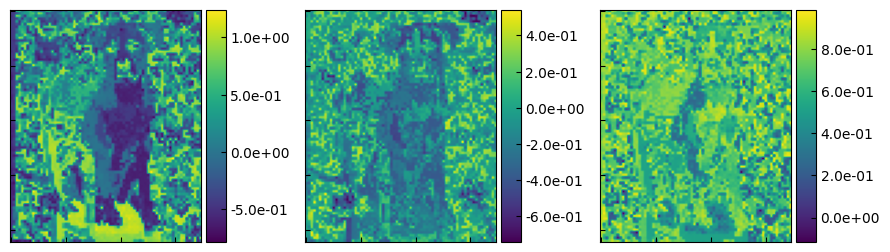

In [21]:
embedding_maps(encode, image)


* This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables

## We know that we only have 3 intrinsic latent variables

# Instantiates the model

In [22]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [23]:
summary(model, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]              33
           Encoder-2                    [-1, 3]               0
            Linear-3                   [-1, 10]              40
           Decoder-4                   [-1, 10]               0
Total params: 73
Trainable params: 73
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


* Encoder with 3 latent dimensions
* Decoder with with size 10 --> same as orignal spectral length
* Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample

In [24]:
train_iterator = torch.utils.data.DataLoader(X_train, batch_size=256, shuffle=True)


In [ ]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device = device)


In [26]:
encode, decode = transform_nn(dog_data, encoder, decoder, device = device)


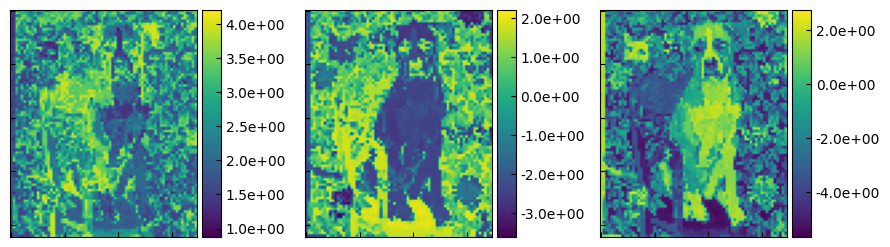

In [27]:
embedding_maps(encode, image)


* This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables

# Generator
* Now we want to see how the spectra changes as we traverse the latent space

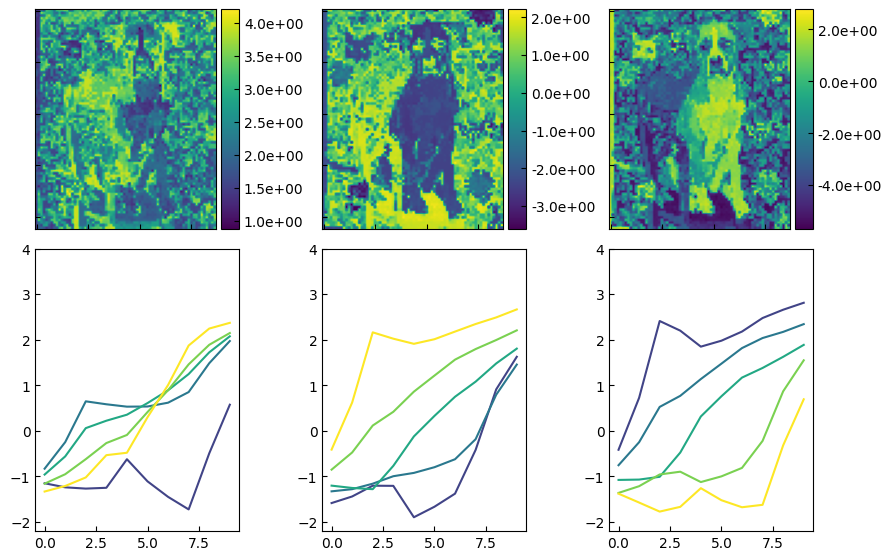

In [28]:
latent_generator(decoder, encode, image, 5, 10, device = device)


# Recurrent Neural Network Autoencoders
* The above example did not consider the temporal information in the data. 
* This can be improved by using a recurrent neural network that processes each time step sequentially.
* To add an understanding about the short and long term information in the data you can add memory and forget logic as a learnable parameter.

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/Autoencoder_Med.png?raw=true)

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/LSTM%20Node.png?raw=true)

In [35]:
latent_dim = 12

# input (batch,)
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


# LSTM Autoencoder with 12 latent dimensions

In [36]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [37]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


In [ ]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


In [42]:
encode, decode = transform_nn(dog_data, encoder, decoder, device= device)


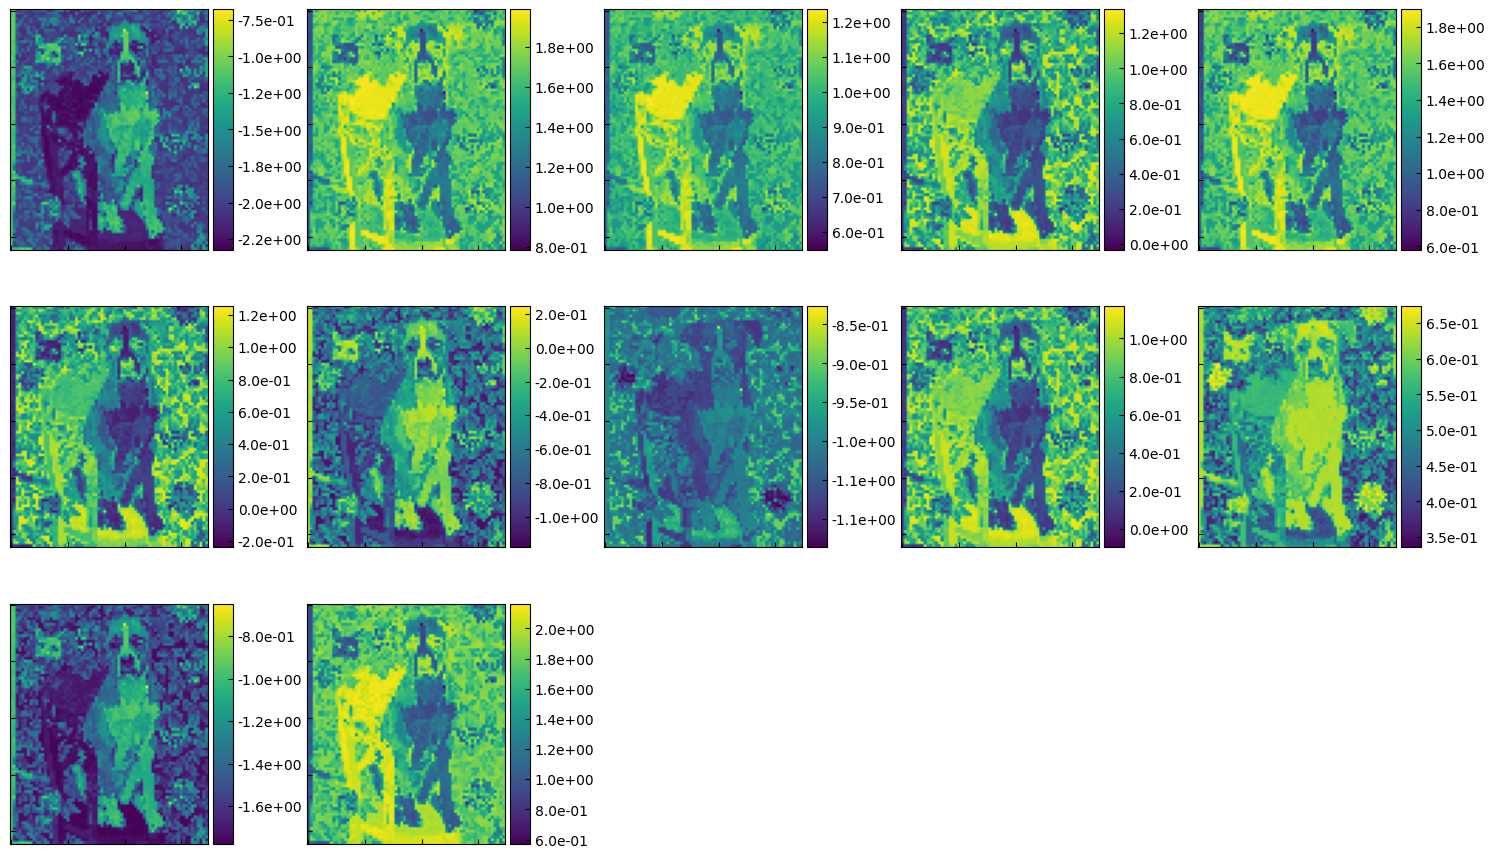

In [43]:
embedding_maps(encode, image)


* This does not really mean too much because the latent variables are all competing with one another

# Let's Try with 3 latent variables

In [44]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [45]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [46]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


In [ ]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device = device)


In [48]:
encode, decode = transform_nn(dog_data, encoder, decoder, device = device)


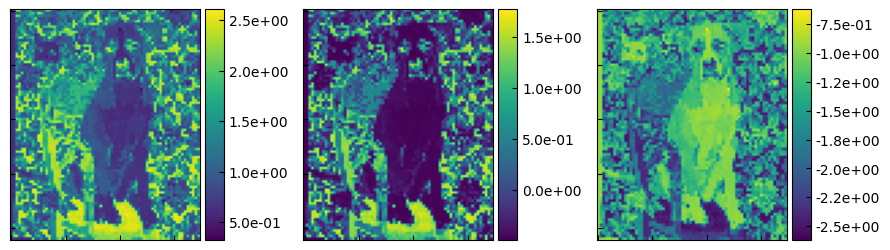

In [49]:
embedding_maps(encode, image)


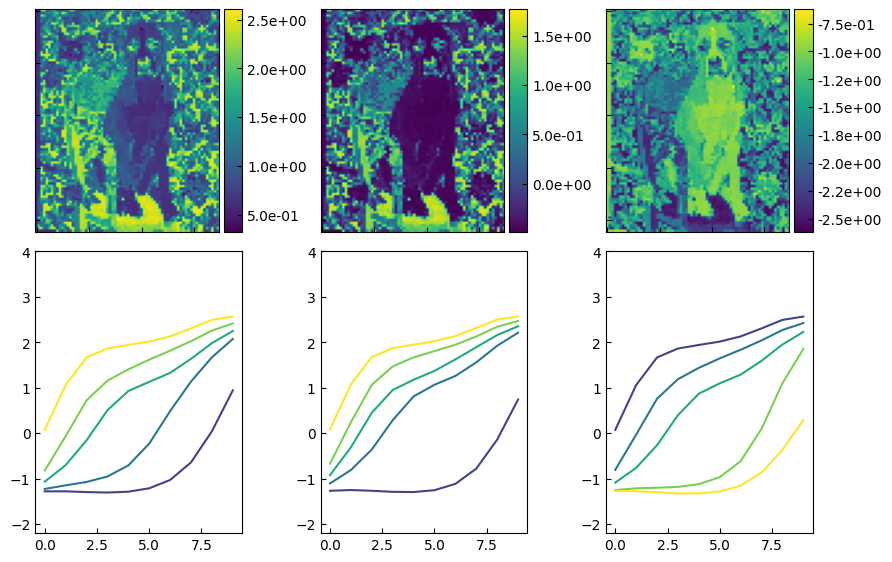

In [50]:
latent_generator(decoder, encode, image, 5, 10, device = device)


* This once again is very hard to interpret and the spectra do not really contain the necessary details

# Disentanglement
## Regularization
![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/L1_reg.png?raw=true)


In [51]:
latent_dim = 12

# input (batch,)
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)  # add a relu
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [52]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [53]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [54]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


In [ ]:
torch.manual_seed(0)
Train(
    model, encoder, decoder, train_iterator, optimizer, 500, coef=1e-3, mse=False, device=device,
)


In [57]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


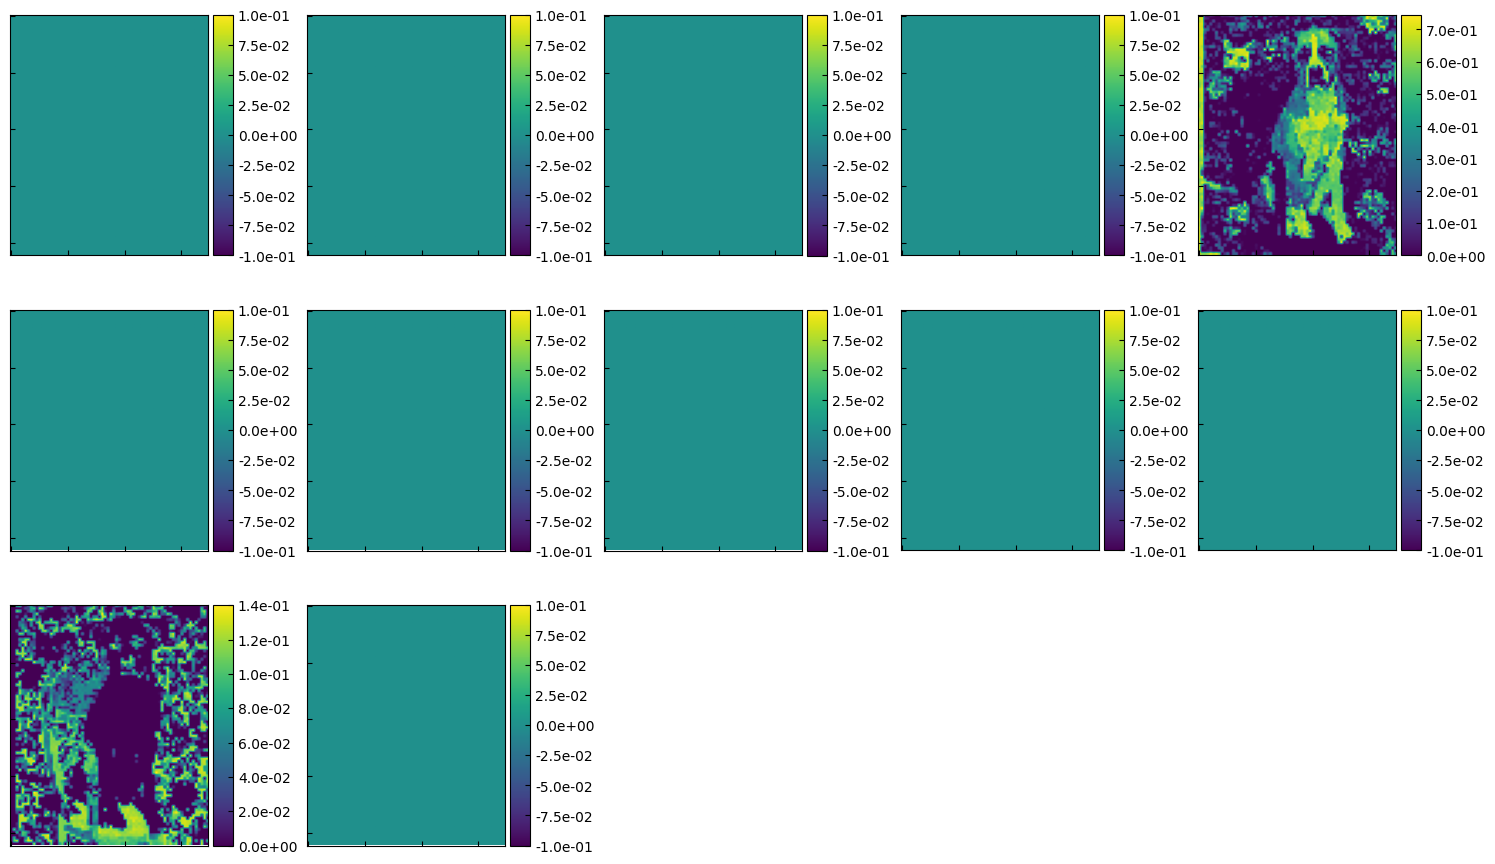

In [58]:
embedding_maps(encode, image)


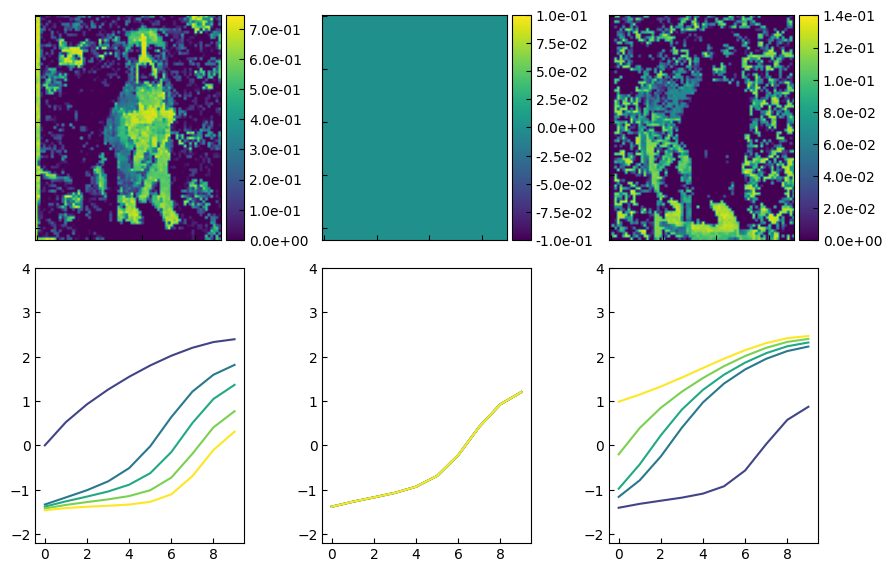

In [61]:
latent_generator(decoder, encode, image, 5, 10, indx=[4, 3, 10], device=device)


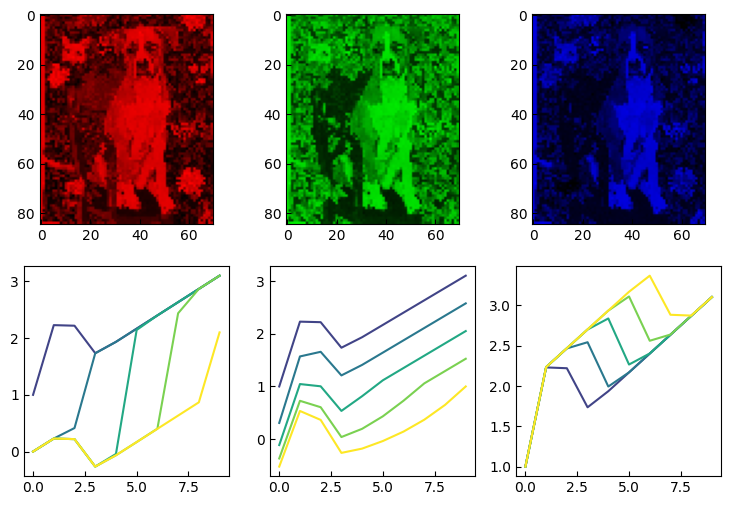

In [64]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)


In [65]:
from IPython.display import HTML

# Youtube
HTML(
    '<iframe width="560" height="315" src="https://www.youtube.com/embed/ElTwQClLsW0" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)


c:\Conda\envs\m3_learning\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Beta Variational Autoencoder
* Constrict and sample the latent space from some prior distribution --> generally a gaussian distribution

# Normal Autoencoder
![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/VAE1.png?raw=true)

# VAE
* Encoder identifies some distribution --> generates from that distribution
![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/VAE2.png?raw=true)

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/VAE3.png?raw=true)

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/VAE4.png?raw=true)

In [73]:
latent_dim = 12

# input (batch,)
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()
        self.mn = nn.Linear(self.latent_dim, self.latent_dim)
        self.sd = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x):
        #     x = x.transpose(1,2)

        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)
        mn = self.mn(x)
        sd = self.sd(x)
        std = torch.exp(sd * 0.5).cuda()
        eps = torch.normal(0, 1, size=std.size()).cuda()
        out = eps.mul(std).add_(mn).cuda()

        return out, mn, sd


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [74]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [75]:
def Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    epochs,
    coef=0,
    coef_1=0,
    ln_parm=1,
    beta_step_size=0,
    epoch_per_beta=10,
    initial_epochs=10,
    device = device
):

    N_EPOCHS = epochs
    best_train_loss = float("inf")

    for epoch in range(N_EPOCHS):

        if epoch < initial_epochs:

            beta = 0
        else:

            beta = ((epoch - initial_epochs) // epoch_per_beta + 1) * beta_step_size

        train_loss = loss_function(
            model,
            encoder,
            decoder,
            train_iterator,
            optimizer,
            coef,
            coef_1,
            ln_parm,
            beta=beta,
            mse=False,
        )

        train_loss /= len(train_iterator)
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")
        print(".............................")

        if (
            (epoch - initial_epochs) // epoch_per_beta
            == (epoch - initial_epochs) / epoch_per_beta
        ) and (epoch >= initial_epochs):

            best_train_loss = float("inf")

        if best_train_loss > train_loss:
            best_train_loss = train_loss
            patience_counter = 1
            checkpoint = {
                "net": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "encoder": encoder.state_dict(),
                "decoder": decoder.state_dict(),
            }
            if epoch >= 0:
                torch.save(
                    checkpoint, f"./test__Train_Loss:{train_loss:.4f}-{epoch}.pkl"
                )


In [ ]:
torch.manual_seed(0)
Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    beta_step_size=0.05,
    epoch_per_beta=100,
    initial_epochs=200,
    device = device,
)


In [77]:
encoded_spectra, mn, sd = encoder(
    torch.tensor(np.atleast_3d(dog_data), dtype=torch.float32).to(device)
)
decoded_spectra = decoder(encoded_spectra)


In [78]:
encoded_spectra = encoded_spectra.to("cpu")
encoded_spectra = encoded_spectra.detach().numpy()
decoded_spectra = decoded_spectra.to("cpu")
decoded_spectra = decoded_spectra.detach().numpy()

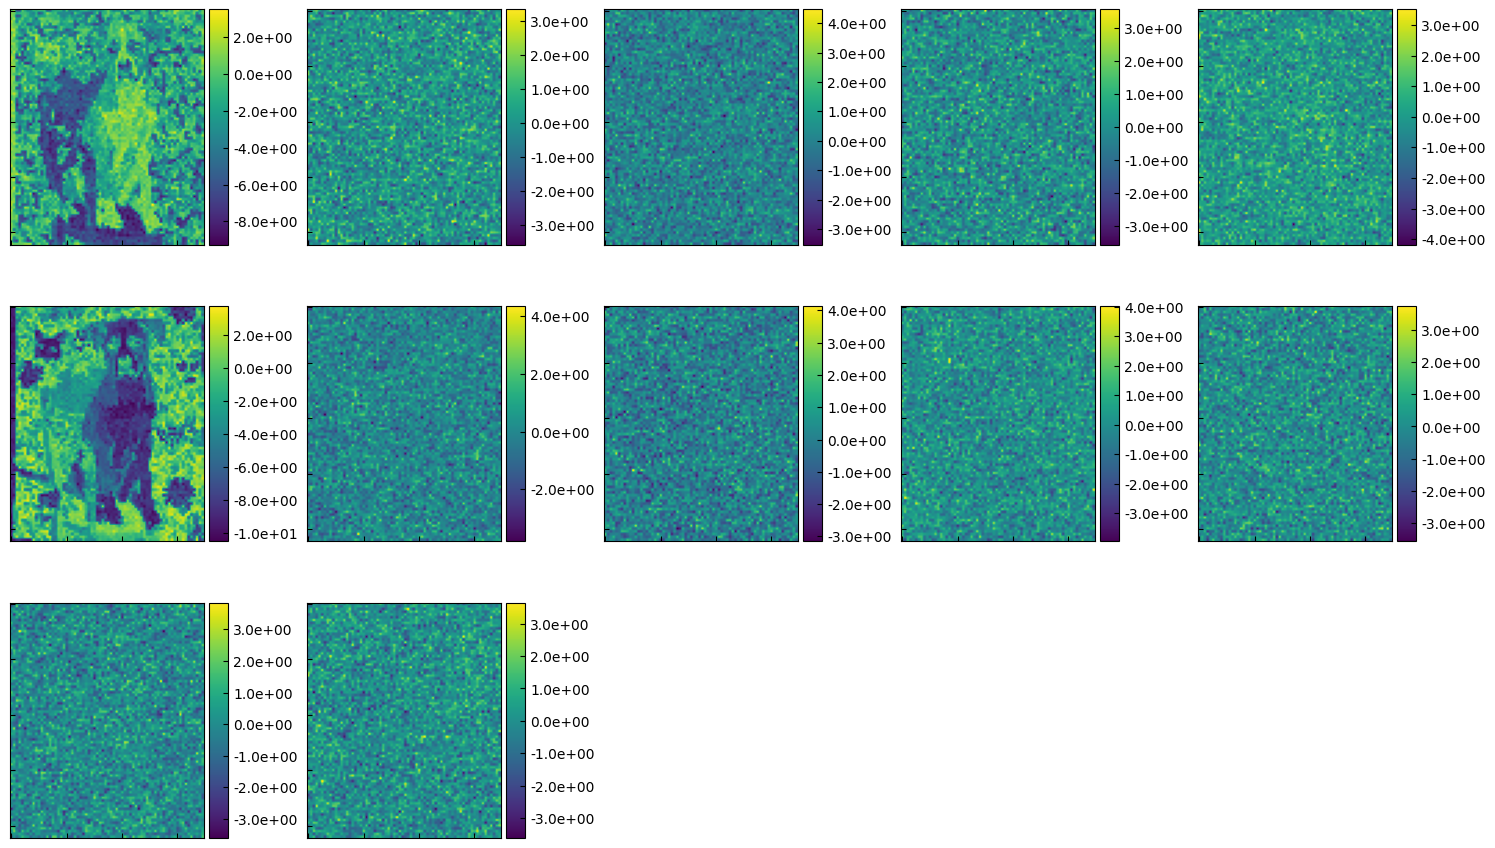

In [79]:
embedding_maps(encoded_spectra, image)


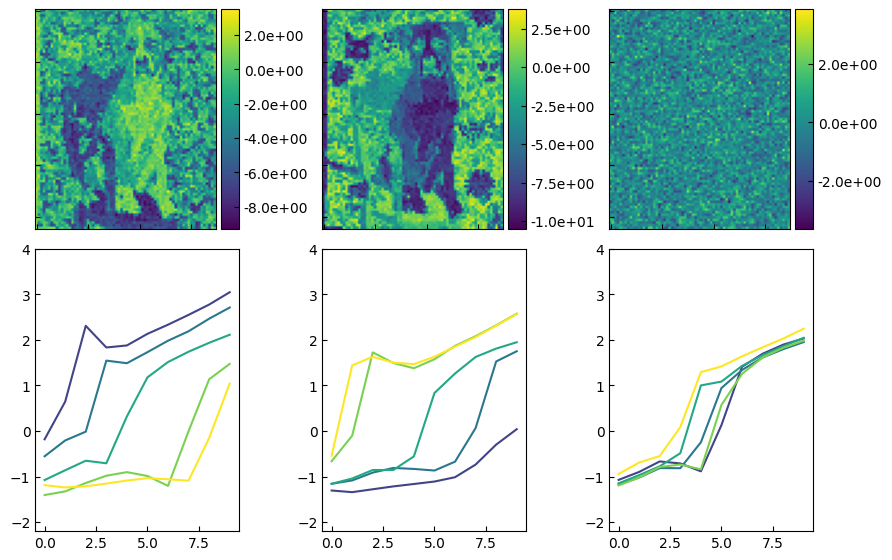

In [81]:
latent_generator(decoder, encoded_spectra, image, 5, 10, indx=[0, 5, 10], device = device)


* disentanglement with $\beta$ VAE requires careful control of optimiztion. 